In [1]:
import numpy as np
import pandas as pd

import re
import json

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
data = pd.read_json(r"../data/news_headlines/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [6]:
data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [7]:
data = data.rename(columns = {"is_sarcastic":"Sarcasm","headline":"Headline"})

In [8]:
data = data.drop("article_link",axis=1)
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sarcasm   28619 non-null  int64 
 1   Headline  28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [10]:
data.isnull().sum()

Sarcasm     0
Headline    0
dtype: int64

In [11]:
data["Sarcasm"].value_counts()

0    14985
1    13634
Name: Sarcasm, dtype: int64

<AxesSubplot:title={'center':'Non-Sarcastic vs. Sarcastic'}, xlabel='Sarcasm', ylabel='count'>

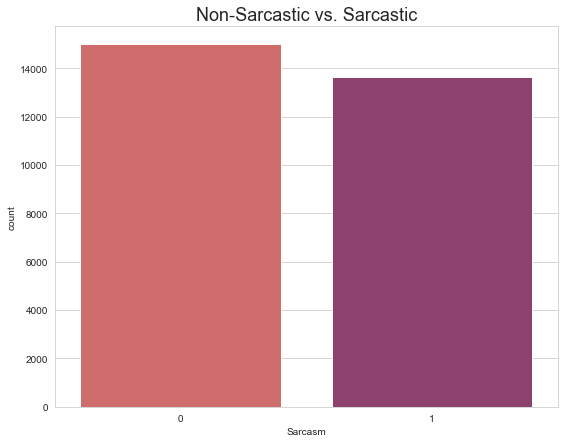

In [12]:
sns.set_style("whitegrid")

plt.figure(figsize = (9,7))

plt.title("Non-Sarcastic vs. Sarcastic", fontsize=18)
sns.countplot(x="Sarcasm",data=data, palette="flare")

In [13]:
data.duplicated(subset=["Headline"]).value_counts()

False    28503
True       116
dtype: int64

In [14]:
dupes = data[data.duplicated(subset=["Headline"])==True]
dupes.head()

,Sarcasm,Headline
1780,1,willow rented
3978,1,all y'all urged to go fuck yo' selves
4771,0,sunday roundup
4904,1,tammys of the world demand to be taken seriously
5092,0,the funniest tweets from parents this week


In [15]:
data = data.drop_duplicates(subset=["Headline"])

In [16]:
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [17]:
data[data["Headline"].str.contains("-")].head()

,Sarcasm,Headline
7,1,richard branson's global-warming donation near...
16,1,area boy enters jumping-and-touching-tops-of-d...
19,0,lin-manuel miranda would like to remind you to...
34,1,new york introduces shoe-sharing program for c...
40,0,the best clothes for the man-child in your life


In [18]:
data[data["Headline"].str.contains("/")].head()

,Sarcasm,Headline
384,0,if i have gay children: 4 promises from a chri...
821,1,google's 9/11 homepage design stirs controversy
1169,1,encouraging report from radical extremist thin...
1209,0,this is what it was like to go to the airport ...
1413,0,barack obama makes last-minute push to block s...


In [19]:
def clean_text(text):
    text = text.lower()
    
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    
    return text

In [20]:
headlines = data["Headline"].values.tolist()

In [21]:
clean_text(headlines[24])

'bill clinton shoots down republicans i strongly supported obamacare'

In [22]:
cleaned = []
for string in headlines:
    string = clean_text(string)
    cleaned.append(string) 

In [23]:
data["Headline"] = cleaned
data.head()

,Sarcasm,Headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


In [24]:
data_cloud = data.copy()

In [25]:
sarcasm = data_cloud[data_cloud["Sarcasm"] == 1]

In [26]:
normal = data_cloud[data_cloud["Sarcasm"] == 0]

In [27]:
stopwords = set(STOPWORDS)

In [28]:
text1 = " ".join(line for line in sarcasm["Headline"])

In [29]:
text2 = " ".join(line for line in normal["Headline"])

In [30]:
sarcasm = list(data["Sarcasm"].values)
headlines = list(data["Headline"].values)

In [31]:
vocab_size = 7500
embedding_dim = 16
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [32]:
training_size = 23000

In [33]:
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]

training_sarcasm = sarcasm[0:training_size]
testing_sarcasm = sarcasm[training_size:]

In [34]:
training_headlines

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep totally nails why congress is falling short on gender racial equality',
 'eat your veggies 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 'mother comes pretty close to using word streaming correctly',
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 'richard bransons globalwarming donation nearly as much as cost of failed balloon trips',
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario',
 'this lesbian is considered a father in indiana and an amazing one at that',
 'amanda peet told her daughter sex is a special hug',
 'what to know regarding current treatments for ebola',
 'chris christie suggests hillary clinton was to blame for boko harams kidnapping of hundreds of schoolgirls',
 'ford develops new suv that runs purely on gasoline',
 'uber ceo travis kalanick stepping down fr

In [35]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_headlines)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
training_padded = np.array(training_padded)
training_sarcasm = np.array(training_sarcasm)
testing_padded = np.array(testing_padded)
testing_sarcasm = np.array(testing_sarcasm)

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(Flatten())

model1.add(Dense(units=32,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=10,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [39]:
vocab_lenght = ((len(word_index)) + 1)

In [40]:
inputs = tf.keras.Input(shape=(40,))
x = tf.keras.layers.Embedding(
    input_dim=24846,
    output_dim=64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model6.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(model6.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 40, 64)            1590144   
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_5 (Dense)             (None, 128)               327808    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,934,593
Trainable params: 1,934,593
Non-train

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 16)            120000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 28)                476       
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 120,505
Trainable params: 120,505
Non-trainable params: 0
_________________________________________________________________


In [42]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 16)            120000    
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                20512     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [ ]:
history = model.fit(training_padded, training_sarcasm, epochs=3, validation_data=(testing_padded, testing_sarcasm), verbose=2)

In [ ]:
history = model1.fit(training_padded, training_sarcasm, epochs=3, validation_data=(testing_padded, testing_sarcasm), verbose=2)

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save(r"models/")

In [ ]:
model1.save(r"models\Model2")